In [1]:
import requests
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from tensorflow import keras
import os

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import requests
from datetime import datetime
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer,OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import MeanSquaredError
from tensorflow.keras import regularizers
import numpy as np

from sklearn.metrics import mean_squared_error

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Dec  4 08:03:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

set up tpu

# Load data

In [3]:
url = "https://query1.finance.yahoo.com/v7/finance/download/000001.SS?period1=867801600&period2=1606953600&interval=1d&events=history&includeAdjustedClose=true"
# url = 'https://query1.finance.yahoo.com/v7/finance/download/688981.SS?period1=1594857600&period2=1607040000&interval=1d&events=history&includeAdjustedClose=true'

In [4]:
btc = pd.read_csv(url)
btc['Date'] = pd.to_datetime(btc['Date'])
btc.set_index('Date', inplace=True)

In [5]:
btc.tail(2)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-12-01,3388.989990,3457.639893,3386.909912,3451.939941,3451.939941,316200.0
2020-12-02,3453.518066,3465.729004,3435.871094,3449.381104,3449.381104,312800.0


Text(0, 0.5, 'Price')

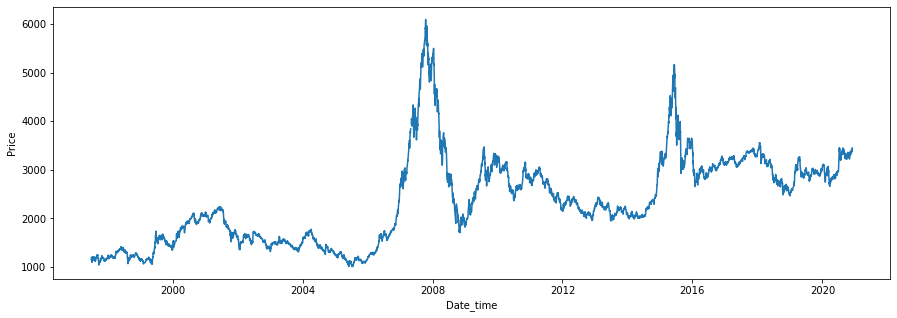

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(btc.Close)
plt.xlabel ('Date_time')
plt.ylabel ('Price')

## Preprocess data

In [7]:
scaler = MinMaxScaler()
# min-max normalization and scale the features in the 0-1 range.
close_price = btc['Close'].values.reshape(-1, 1) 
# The scaler expects the data to be shaped as (x, y)
scaled_close = scaler.fit_transform(close_price)
# removing NaNs (if any)
scaled_close = scaled_close[~np.isnan(scaled_close)] 
# reshaping data after removing NaNs
scaled_close = scaled_close.reshape(-1, 1) 


print(scaled_close.shape)

(5842, 1)


We will use past 150 days datato predict future 3 days price

![](https://www.tensorflow.org/tutorials/structured_data/images/raw_window_24h.png)

We will implement a window generator to generate a series of data shown in this picture.

In [8]:
SEQ_LEN = 10
OFFSET = 3

In [9]:
class WindowGenerator():
    def __init__(self, input_width, offset, data, train_split):
        self.data = data
        self.input_width = input_width
        self.offset = offset
        self.train_split = train_split
    
    def to_sequences(self):
        """
        Return both data and label
        """
        data_len = len(self.data)
        ret = []
        ret_label = []
        for i in range(data_len - self.offset - self.input_width + 1):
            tmp = self.data[i : i + self.input_width ]
            tmp_label = self.data[i + self.input_width + self.offset - 1]
            ret.append(tmp)
            ret_label.append(tmp_label)

        return np.array(ret), np.array(ret_label)

    def split(self):
        x, y = self.to_sequences()
        num_train = int((1 - self.train_split) * x.shape[0])
        X_train = x[:num_train]
        y_train = y[:num_train]
        X_test = x[num_train:]
        y_test = y[num_train:]
        return X_train, y_train, X_test, y_test


wg = WindowGenerator(data=scaled_close, input_width=SEQ_LEN, offset=OFFSET, train_split=0.1)
X_train, y_train, X_test, y_test = wg.split()
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(5247, 10, 1) (583, 10, 1)
(5247, 1) (583, 1)


# Training

## Build model

In [10]:
from tensorflow.keras.layers import Bidirectional, Dropout, LSTM, Dense, Activation

In [11]:
DROPOUT = 0.2 
# 20% Dropout is used to control over-fitting during training
WINDOW_SIZE = SEQ_LEN
model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True), input_shape=(WINDOW_SIZE, X_train.shape[-1])))
"""Bidirectional RNNs allows to train on the sequence data in forward and backward direction."""
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences = True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences = True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))
# output layer
model.add(Dense(units=1))
model.add(Activation('linear'))
"""Output layer has a single neuron (predicted Bitcoin price). We use Linear activation function which activation is proportional to the input."""
BATCH_SIZE = 64
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 10, 20)            960       
_________________________________________________________________
dropout (Dropout)            (None, 10, 20)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 10, 40)            6560      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 40)            0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 10, 40)            9760      
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 40)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 20)                4


## Train model

In [12]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.legend()
  plt.show()



Epoch 1/1000
74/74 [==============================] - 3s 42ms/step - loss: 0.0255 - mae: 0.0969 - mse: 0.0255 - val_loss: 0.0104 - val_mae: 0.0999 - val_mse: 0.0104
Epoch 2/1000
74/74 [==============================] - 1s 16ms/step - loss: 0.0084 - mae: 0.0642 - mse: 0.0084 - val_loss: 2.6337e-04 - val_mae: 0.0121 - val_mse: 2.6337e-04
Epoch 3/1000
74/74 [==============================] - 1s 16ms/step - loss: 0.0016 - mae: 0.0304 - mse: 0.0016 - val_loss: 5.0509e-04 - val_mae: 0.0191 - val_mse: 5.0509e-04
Epoch 4/1000
74/74 [==============================] - 1s 15ms/step - loss: 0.0011 - mae: 0.0217 - mse: 0.0011 - val_loss: 3.2762e-04 - val_mae: 0.0143 - val_mse: 3.2762e-04
Epoch 5/1000
74/74 [==============================] - 1s 15ms/step - loss: 0.0017 - mae: 0.0269 - mse: 0.0017 - val_loss: 2.8728e-04 - val_mae: 0.0130 - val_mse: 2.8728e-04
Epoch 6/1000
74/74 [==============================] - 1s 16ms/step - loss: 0.0025 - mae: 0.0348 - mse: 0.0025 - val_loss: 2.3659e-04 - val_mae:

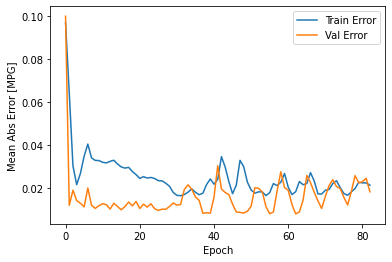

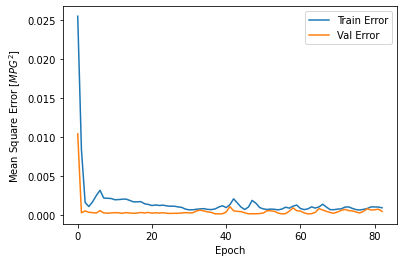

In [13]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)
history = model.fit(X_train, y_train, epochs=1000, batch_size=BATCH_SIZE, shuffle=False, validation_split=0.1, callbacks=[early_stop]) 
plot_history(history)

# Testing

In [14]:
# prediction on test data
y_pred = model.predict(X_test) 
# invert the test to original values
y_test_inverse = pd.DataFrame(scaler.inverse_transform(y_test)) 
# assigning datetime
y_test_inverse.index = btc.index[-len(y_test):] 
print('Test data:',)
print(y_test_inverse.tail(3)); print();
# invert the prediction to understandable values
y_pred_inverse = pd.DataFrame(scaler.inverse_transform(y_pred)) 
# assigning datetime
y_pred_inverse.index = y_test_inverse.index 
print('Prediction data:',)
print(y_pred_inverse.tail(3))
# print(y_train.shape)

Test data:
                      0
Date                   
2020-11-30  3391.760010
2020-12-01  3451.939941
2020-12-02  3449.381104

Prediction data:
                      0
Date                   
2020-11-30  3472.610596
2020-12-01  3473.817871
2020-12-02  3480.749268


In [22]:
print(f'MAE {mean_absolute_error(y_test, y_pred)}')
print(f'MSE {mean_squared_error(y_test, y_pred)}')
print(f'RMSE {np.sqrt(mean_squared_error(y_test, y_pred))}')

MAE 0.016881823811182695
MSE 0.00046803935067563616
RMSE 0.021634217126478974


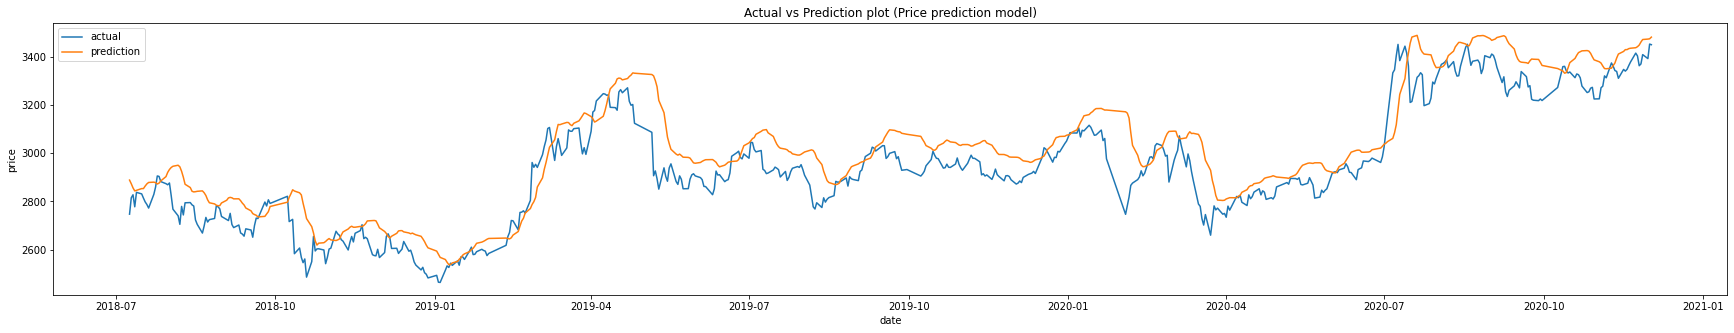

In [23]:
plt.figure(figsize = (30,5))
plt.plot(y_test_inverse)
plt.plot(y_pred_inverse)
plt.title('Actual vs Prediction plot (Price prediction model)')
plt.ylabel('price')
plt.xlabel('date')
plt.legend(['actual', 'prediction'], loc='upper left')
plt.show()

In [17]:
today_price = scaled_close[-SEQ_LEN:]
today_price = np.expand_dims(today_price, axis=0)
print(today_price.shape, X_test.shape)
tmr_prediction = model.predict(today_price)
scaler.inverse_transform(tmr_prediction)[0][0]

(1, 10, 1) (583, 10, 1)


3508.1355

# LSTM with sentiment score

By only using previous stock data to predict future price may cause in accurate future predictions, so we want to use the power of the social media. 

In this section, we will try to analyze the future stock data in two directions:

1. Use lstm to predict future sentiment score to predict stock price.

2. We will modify the model above to add one 

## Analyze sentiment

In [18]:
from datetime import datetime
sentiment_files_path = '/content/drive/MyDrive/courses/HKUST/MSBD5012/project/sentiments.csv'

In [19]:
def parse_time(time):
    try:
        return datetime.strptime(time, '%Y-%m-%d %H:%M:%S.%f+00')
    except Exception:
        return None

sentiments = pd.read_csv(sentiment_files_path)
sentiments.info()
sentiments['Time'] = sentiments['Time'].apply(parse_time)
sentiments = sentiments.dropna()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614836 entries, 0 to 614835
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  614836 non-null  int64  
 1   Keyword     614836 non-null  object 
 2   content     614453 non-null  object 
 3   Time        614832 non-null  object 
 4   Rank        614832 non-null  float64
 5   Number      614828 non-null  float64
 6   sentiments  612742 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 32.8+ MB


In [20]:
sentiments['Date'] = sentiments['Time'].apply(lambda date: date.date())
grouped = sentiments[['Date', 'sentiments']].groupby('Date').mean()
grouped = grouped.reset_index()
grouped

,Date,sentiments
0,2020-11-14,0.776240
1,2020-11-15,0.752614
2,2020-11-16,0.740375
3,2020-11-17,0.739457
4,2020-11-18,0.693168
5,2020-11-19,0.719513
6,2020-11-20,0.735112
7,2020-11-21,0.738899
8,2020-11-22,0.676612
9,2020-11-23,0.696438


## Daily sentiment score with stock score

In [21]:
data = btc.Close.loc['2020-11-14':]

data = data.reset_index()
data['Date'] = data['Date'].apply(lambda x: x.date())
data

,Date,Close
0,2020-11-16,3346.968994
1,2020-11-17,3339.899902
2,2020-11-18,3347.302979
3,2020-11-19,3363.087891
4,2020-11-20,3377.729980
5,2020-11-23,3414.489990
6,2020-11-24,3402.822998
7,2020-11-25,3362.326904
8,2020-11-26,3369.732910
9,2020-11-27,3408.306885


No handles with labels found to put in legend.


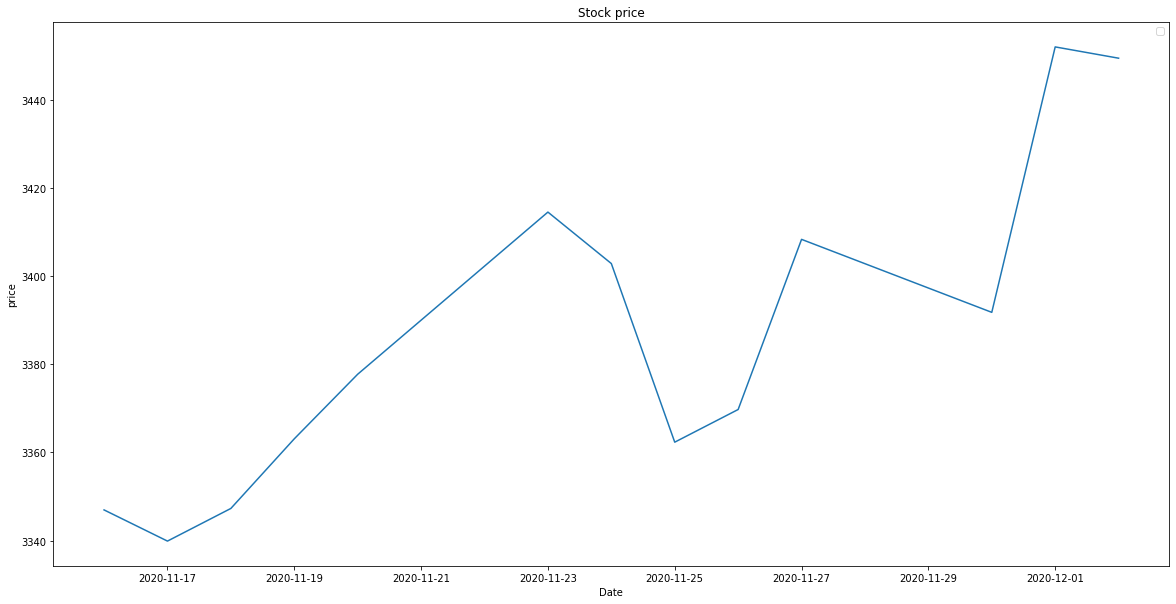

In [173]:
plt.figure(figsize=(20, 10))
plt.plot(data['Date'], data['Close'])
plt.title('Stock price')
plt.xlabel('Date')
plt.ylabel('price')
plt.legend()

No handles with labels found to put in legend.


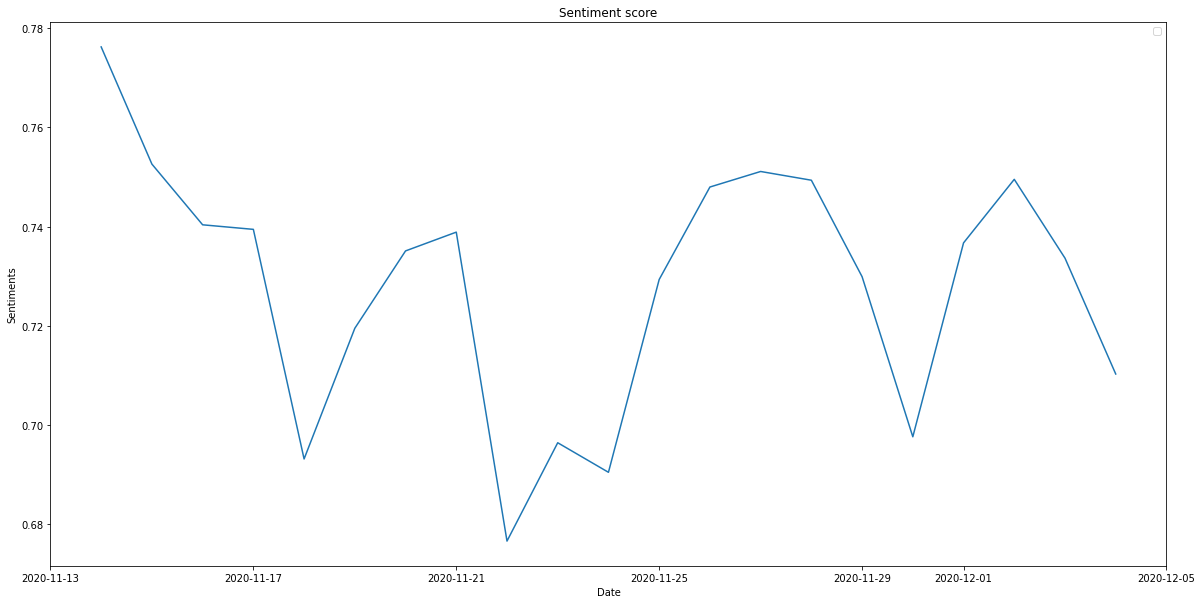

In [174]:
plt.figure(figsize=(20, 10))
plt.plot(grouped['Date'], grouped['sentiments'])
plt.title('Sentiment score')
plt.xlabel('Date')
plt.ylabel('Sentiments')
plt.legend()

## Merge data with sentiment

In [48]:
merged = grouped.merge(data, on='Date', how='inner')
merged

,Date,sentiments,Close
0,2020-11-16,0.740375,3346.968994
1,2020-11-17,0.739457,3339.899902
2,2020-11-18,0.693168,3347.302979
3,2020-11-19,0.719513,3363.087891
4,2020-11-20,0.735112,3377.729980
5,2020-11-23,0.696438,3414.489990
6,2020-11-24,0.690481,3402.822998
7,2020-11-25,0.729346,3362.326904
8,2020-11-26,0.747991,3369.732910
9,2020-11-27,0.751125,3408.306885


In [56]:
# def generate_training_data(data: pd.DataFrame, prediction_label, cat_vars=['id', 'IsWeekend','IsHoliday','Hour modify', 'Weather'], 
#                            num_vars=['Temperature', 'Pressure', 'Humidity', 'Cloud', 'Wind degree'], 
#                            should_reshape=True, should_split = True):
#     x = data.copy()
#     y = x[prediction_label].to_list()
#     y = np.array(y)

#     numeric_transformer=Pipeline(steps=[
#     ('scaler', RobustScaler())])
#     categorical_transformer=Pipeline(steps=[
#     ('oneHot',OneHotEncoder(sparse=False))])

#     preprocessor=ColumnTransformer(transformers=[
#     ('num',numeric_transformer,num_vars),
#     ('cat',categorical_transformer,cat_vars)])

#     data_transformed=preprocessor.fit_transform(x)
#     if should_split:
#         if should_reshape:
#             y = y.reshape(-1, 1)
#             scaler = MinMaxScaler()
#             scaled_y = scaler.fit_transform(y)
#             return train_test_split(data_transformed,scaled_y ,test_size=0.02,random_state=42), scaler
#         else:
#             return train_test_split(data_transformed,y ,test_size=0.02,random_state=42)
#     else:
#         return data_transformed, y

scaler = MinMaxScaler()
scaler2 = MinMaxScaler()
x_data = merged[['Close', 'sentiments']].to_numpy()
y_data = merged[['Close']].to_numpy()
scaled_x = scaler.fit_transform(x_data)
scaled_y = scaler2.fit_transform(y_data)
print(scaled_x)
print(scaled_y)


[[0.06309434 0.82273844]
 [0.         0.80759869]
 [0.06607528 0.04430082]
 [0.20696163 0.47872791]
 [0.33764785 0.73594303]
 [0.66574493 0.09821586]
 [0.56161259 0.        ]
 [0.20016953 0.64086574]
 [0.26627095 0.94831122]
 [0.61055836 1.        ]
 [0.46287121 0.11805199]
 [1.         0.76261199]
 [0.97716141 0.97388203]]
[[0.06309434]
 [0.        ]
 [0.06607528]
 [0.20696163]
 [0.33764785]
 [0.66574493]
 [0.56161259]
 [0.20016953]
 [0.26627095]
 [0.61055836]
 [0.46287121]
 [1.        ]
 [0.97716141]]


In [40]:
SEQ_LEN = 3
OFFSET = 0

In [57]:
wg = WindowGenerator(data=scaled_x, input_width=SEQ_LEN, offset=OFFSET, train_split=0.1)
wg2 = WindowGenerator(data=scaled_y, input_width=SEQ_LEN, offset=OFFSET, train_split=0.1)
X_train, _, X_test, _ = wg.split()
_, y_train, _, y_test = wg2.split()
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(9, 3, 2) (2, 3, 2)
(9, 1) (2, 1)


## Stock price with sentiment

In [58]:
print(X_train[0], y_train[0])

[[0.06309434 0.82273844]
 [0.         0.80759869]
 [0.06607528 0.04430082]] [0.06607528]


In [59]:
DROPOUT = 0.2 
# 20% Dropout is used to control over-fitting during training
WINDOW_SIZE = SEQ_LEN
model = keras.Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True), input_shape=(WINDOW_SIZE, X_train.shape[-1])))
"""Bidirectional RNNs allows to train on the sequence data in forward and backward direction."""
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences = True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM((WINDOW_SIZE * 2), return_sequences = True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=False)))
# output layer
model.add(Dense(units=1))
model.add(Activation('linear'))
"""Output layer has a single neuron (predicted Bitcoin price). We use Linear activation function which activation is proportional to the input."""
BATCH_SIZE = 64
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_12 (Bidirectio (None, 3, 6)              144       
_________________________________________________________________
dropout_9 (Dropout)          (None, 3, 6)              0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 3, 12)             624       
_________________________________________________________________
dropout_10 (Dropout)         (None, 3, 12)             0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 3, 12)             912       
_________________________________________________________________
dropout_11 (Dropout)         (None, 3, 12)             0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 6)                

Epoch 1/1000
1/1 [==============================] - 2s 2s/step - loss: 0.1822 - mae: 0.3731 - mse: 0.1822 - val_loss: 0.2178 - val_mae: 0.4667 - val_mse: 0.2178
Epoch 2/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.1754 - mae: 0.3638 - mse: 0.1754 - val_loss: 0.2137 - val_mae: 0.4622 - val_mse: 0.2137
Epoch 3/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.1736 - mae: 0.3615 - mse: 0.1736 - val_loss: 0.2096 - val_mae: 0.4578 - val_mse: 0.2096
Epoch 4/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.1712 - mae: 0.3580 - mse: 0.1712 - val_loss: 0.2056 - val_mae: 0.4534 - val_mse: 0.2056
Epoch 5/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.1703 - mae: 0.3556 - mse: 0.1703 - val_loss: 0.2016 - val_mae: 0.4491 - val_mse: 0.2016
Epoch 6/1000
1/1 [==============================] - 0s 21ms/step - loss: 0.1660 - mae: 0.3508 - mse: 0.1660 - val_loss: 0.1978 - val_mae: 0.4447 - val_mse: 0.1978
Epoch 7/1000
1/1 [======

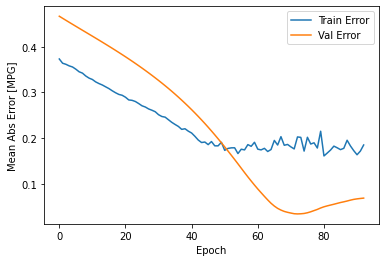

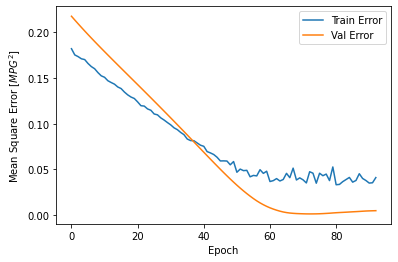

In [60]:
history = model.fit(X_train, y_train, epochs=1000, callbacks=[early_stop], validation_split=0.1, shuffle=False)
plot_history(history)

In [61]:
pred_data = model.predict(X_test)
py =  scaler2.inverse_transform(pred_data)
ty = scaler2.inverse_transform(y_test)

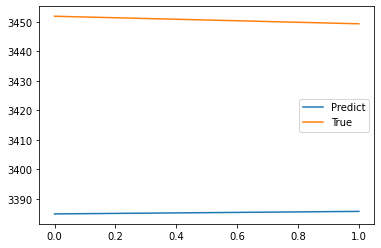

In [63]:
plt.plot(py, label='Predict')
plt.plot(ty, label='True')
plt.legend()

# Conclusion

Due to the current volume of data, we may not be able to use sentiment data to train the model. However, according to the observation, we found that social media's attitude will impact the stock data which proved the original paper's idea.